In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchdiffeq import odeint

import numpy as np
import matplotlib.pyplot as plt

import sys 
sys.path.append('../src')

from mechanical_systems import DoubleMassSpring
from plot_utils import *
from autoregressive import autoregressive_rollout_ivp

from models import *

In [2]:
device = torch.device("cpu")
# device = torch.device("mps")
print("Device: ", device)

Device:  cpu


In [ ]:
# inputs[0, 0, :] = tensor([0.0929, 0.5351, 0.4993, 0.4952])

In [19]:
system = DoubleMassSpring(k1=10, k2=7.5)

n_simulations = 1
t_init = 0
t_final = 20
n_steps = 100 * (t_final - t_init)

t_span = (t_init, t_final)
t_eval = np.linspace(t_init, t_final, n_steps)

dataset, inputs, outputs = system.generate_dataset(
    num_simulations=n_simulations,
    initial_conditions=torch.tensor([0.15, 0.6, 0.5, 0.5]),
    t_span=t_span,
    t_eval=t_eval,
    noise_level=0.015,
    return_trajectories=True,
)

train_size = 500
test_size = len(dataset) - train_size

train_inputs, train_outputs = inputs[:, :train_size, :], outputs[:, :train_size, :]
test_inputs, test_outputs = inputs[:, train_size:, :], outputs[:, train_size:, :]

train_dataset = Subset(dataset, range(train_size))
test_dataset = Subset(dataset, range(train_size, len(dataset)))

print("Train size: ", len(train_dataset))
print("Test size: ", len(test_dataset))

Train size:  500
Test size:  1500


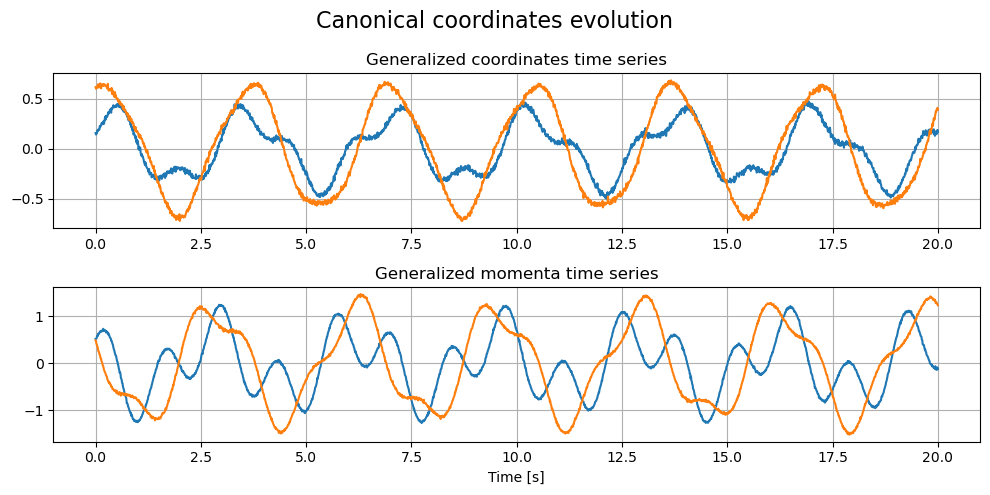

In [20]:
plot_canonical_time_series(t_eval, inputs[0, :, :])

In [21]:
train_loader = DataLoader(
    train_dataset, batch_size=len(train_dataset), shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=False
)

In [22]:
# Common models and training parameters
input_dim = train_inputs[0].shape[1]
hidden_dim=256
n_hidden_layers=4

mse_loss_fn = nn.MSELoss()
num_epochs = 2000

### Baseline Model

Use a simple MLP to approximate the state-to-state map

In [23]:
baseline_model = MLP(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=input_dim,
    n_hidden_layers=n_hidden_layers,
).to(device)

optimizer = torch.optim.Adam(
    baseline_model.parameters(),
    lr=1e-4,
)

train_losses_baseline = []
test_losses_baseline = []

for epoch in range(num_epochs):
    
    # Training loop
    train_loss = 0.0
    baseline_model.train() 
    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()

        x_batch = x_batch.to(device).requires_grad_(True)
        y_batch = y_batch.to(device).requires_grad_(True)
        y_pred = baseline_model(x_batch)
        
        loss = mse_loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses_baseline.append(train_loss)

    # Testing loop
    test_loss = 0.0
    baseline_model.eval()
    for x_batch, y_batch in test_loader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = baseline_model(x_batch)

        test_loss += mse_loss_fn(y_pred, y_batch).item()

    test_loss /= len(test_loader)
    test_losses_baseline.append(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f" ---- Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

 ---- Epoch 100/2000
Train Loss: 1.1255, Test Loss: 1.5357
 ---- Epoch 200/2000
Train Loss: 0.0153, Test Loss: 0.2548
 ---- Epoch 300/2000
Train Loss: 0.0127, Test Loss: 0.2707
 ---- Epoch 400/2000
Train Loss: 0.0116, Test Loss: 0.2921
 ---- Epoch 500/2000
Train Loss: 0.0110, Test Loss: 0.3183
 ---- Epoch 600/2000
Train Loss: 0.0105, Test Loss: 0.3461
 ---- Epoch 700/2000
Train Loss: 0.0098, Test Loss: 0.3758
 ---- Epoch 800/2000
Train Loss: 0.0091, Test Loss: 0.4087
 ---- Epoch 900/2000
Train Loss: 0.0086, Test Loss: 0.4437
 ---- Epoch 1000/2000
Train Loss: 0.0082, Test Loss: 0.4789
 ---- Epoch 1100/2000
Train Loss: 0.0079, Test Loss: 0.5141
 ---- Epoch 1200/2000
Train Loss: 0.0072, Test Loss: 0.5513
 ---- Epoch 1300/2000
Train Loss: 0.0069, Test Loss: 0.5882
 ---- Epoch 1400/2000
Train Loss: 0.0067, Test Loss: 0.6256
 ---- Epoch 1500/2000
Train Loss: 0.0061, Test Loss: 0.6623
 ---- Epoch 1600/2000
Train Loss: 0.0059, Test Loss: 0.6991
 ---- Epoch 1700/2000
Train Loss: 0.0055, Test Lo

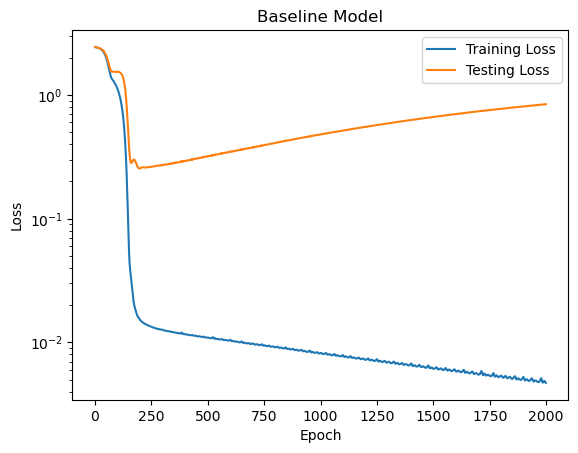

In [25]:
plt.plot(train_losses_baseline, label='Training Loss')
plt.plot(test_losses_baseline, label='Testing Loss')
plt.title('Baseline Model')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

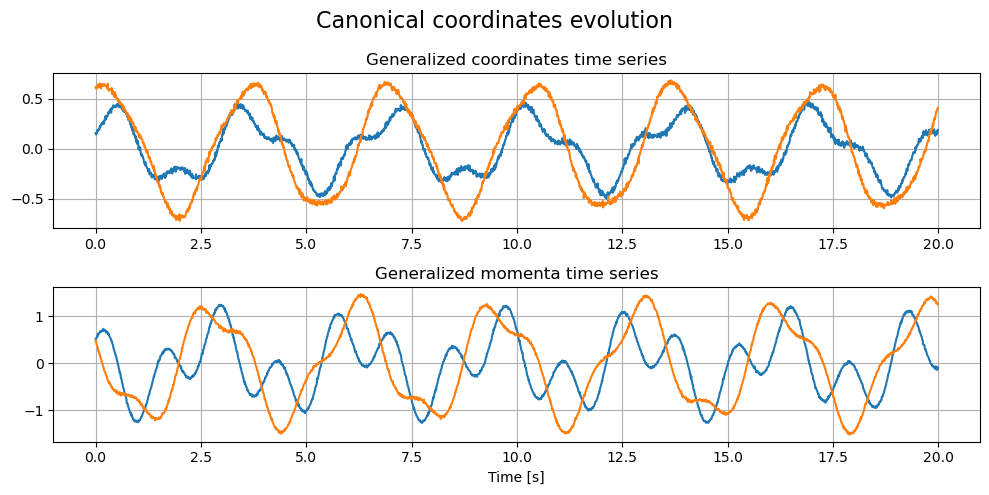

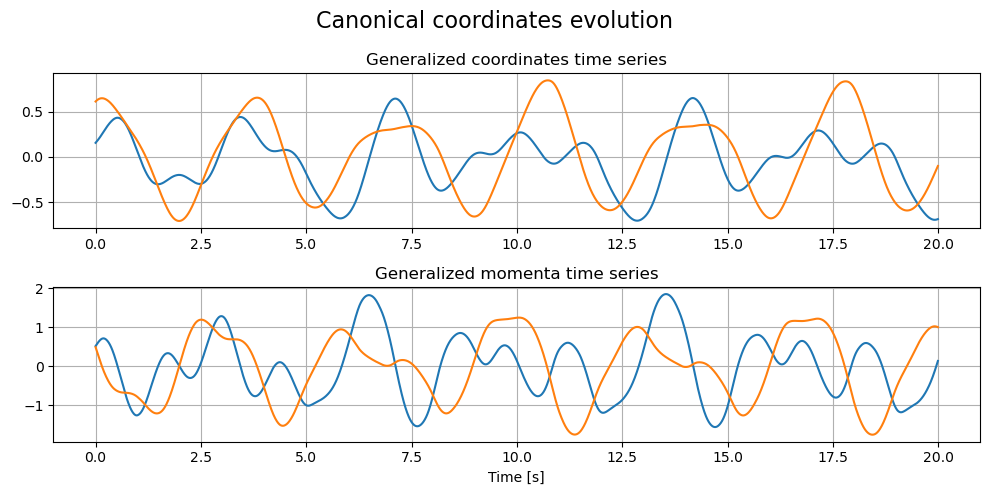

In [26]:
trajectory_truth = inputs[0, :, :]
initial_conditions = trajectory_truth[0, :]

trajectory_baseline_model = autoregressive_rollout_ivp(
    model=baseline_model,
    initial_conditions=initial_conditions,
    t_span=t_span,
    n_steps=n_steps,
)

t_stop = -1
plot_canonical_time_series(t_eval[:t_stop], trajectory_truth[:t_stop])
plot_canonical_time_series(t_eval[:t_stop], trajectory_baseline_model[:t_stop])

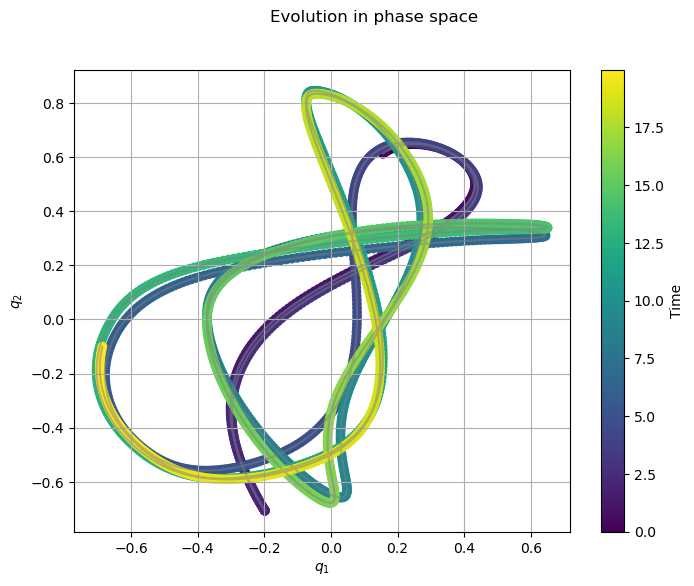

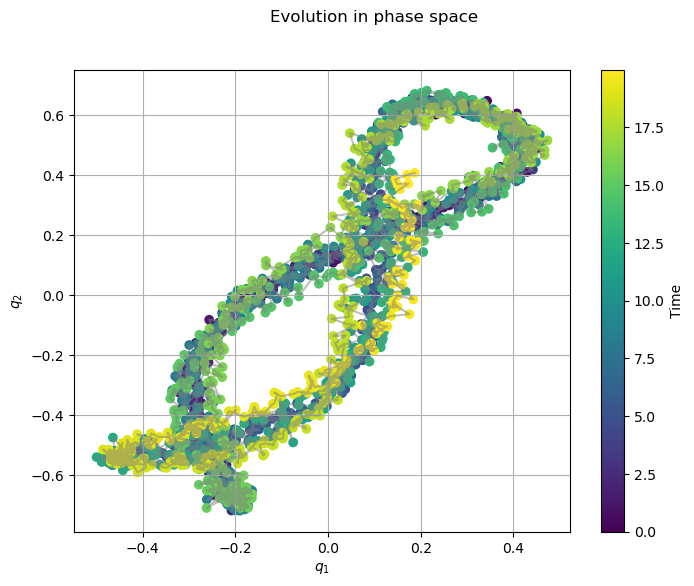

In [27]:
baseline_model_gen_coords = np.array(
    [np.array(system.canonical_to_generalized(trajectory_baseline_model[i, :])) for i in range(n_steps)]
)

ground_truth_gen_coords = np.array(
    [np.array(system.canonical_to_generalized(trajectory_truth[i, :])) for i in range(n_steps)]
)

plot_phase_space_quiver(
    t_eval[:t_stop],
    baseline_model_gen_coords[:t_stop],
    quiver=False,
)
plot_phase_space_quiver(
    t_eval[:t_stop],
    ground_truth_gen_coords[:t_stop],
    quiver=False,
)

### Hamiltonian Neural Network Model

Use a HNN to approximate system dynamics

In [28]:
hamiltonian_core_model = ResMLP(
    input_dim=input_dim,
    output_dim=1,
    hidden_dim=hidden_dim,
    n_hidden_layers=n_hidden_layers,
).to(device)

hamiltonian_model = HamiltonianNeuralNetwork(
    input_dim=input_dim,
    core_model=hamiltonian_core_model,
).to(device)

optimizer = torch.optim.Adam(
    hamiltonian_model.parameters(), 
    lr=1e-5,
)

train_losses = []
test_losses = []
hamiltonian_model.train()

for epoch in range(num_epochs):
    
    train_loss = 0.0
    for x_batch, y_batch in train_loader:

        x_batch = x_batch.to(device).requires_grad_(True)
        y_batch = y_batch.to(device).requires_grad_(True)

        optimizer.zero_grad()

        y_pred = hamiltonian_model(x_batch)
        h = hamiltonian_model.compute_hamiltonian(x_batch)

        mse_loss = mse_loss_fn(y_pred, y_batch)
        h_loss = mse_loss_fn(h, torch.zeros_like(h))
        loss = mse_loss + h_loss
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    test_loss = 0.0
    for x_batch, y_batch in test_loader:  # Cannot turn off gradient because model uses gradients

        x_batch = x_batch.to(device).requires_grad_(True)
        y_batch = y_batch.to(device).requires_grad_(True)

        y_pred = hamiltonian_model(x_batch)
        h_test = hamiltonian_model.compute_hamiltonian(x_batch)
        
        mse_loss_test = mse_loss_fn(y_pred, y_batch).item()
        h_loss_test = mse_loss_fn(h_test, torch.zeros_like(h_test)).item()
        test_loss += mse_loss_test + h_loss_test


    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    if (epoch + 1) % 100 == 0:
        print(f" ---- Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


 ---- Epoch 100/2000
Train Loss: 2.3691, Test Loss: 2.4163
 ---- Epoch 200/2000
Train Loss: 2.0919, Test Loss: 2.1696
 ---- Epoch 300/2000
Train Loss: 1.8040, Test Loss: 1.9195
 ---- Epoch 400/2000
Train Loss: 1.5019, Test Loss: 1.6653
 ---- Epoch 500/2000
Train Loss: 1.2010, Test Loss: 1.4227
 ---- Epoch 600/2000
Train Loss: 0.9269, Test Loss: 1.2129
 ---- Epoch 700/2000
Train Loss: 0.6831, Test Loss: 1.0284
 ---- Epoch 800/2000
Train Loss: 0.4724, Test Loss: 0.8370
 ---- Epoch 900/2000
Train Loss: 0.2917, Test Loss: 0.6543
 ---- Epoch 1000/2000
Train Loss: 0.1637, Test Loss: 0.4989
 ---- Epoch 1100/2000
Train Loss: 0.0969, Test Loss: 0.3801
 ---- Epoch 1200/2000
Train Loss: 0.0656, Test Loss: 0.3067
 ---- Epoch 1300/2000
Train Loss: 0.0518, Test Loss: 0.2643
 ---- Epoch 1400/2000
Train Loss: 0.0448, Test Loss: 0.2375
 ---- Epoch 1500/2000
Train Loss: 0.0426, Test Loss: 0.2179
 ---- Epoch 1600/2000
Train Loss: 0.0404, Test Loss: 0.2051
 ---- Epoch 1700/2000
Train Loss: 0.0403, Test Lo

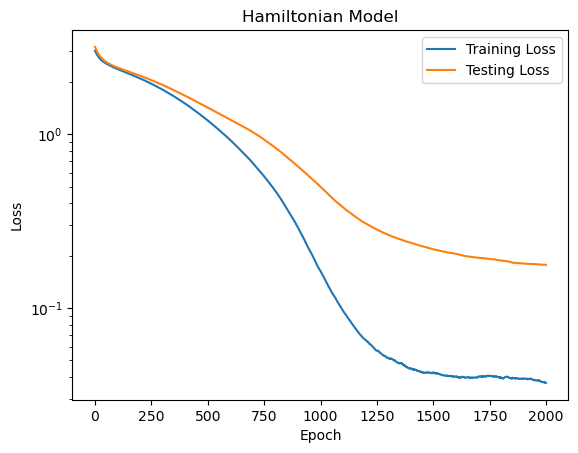

In [29]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Hamiltonian Model')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

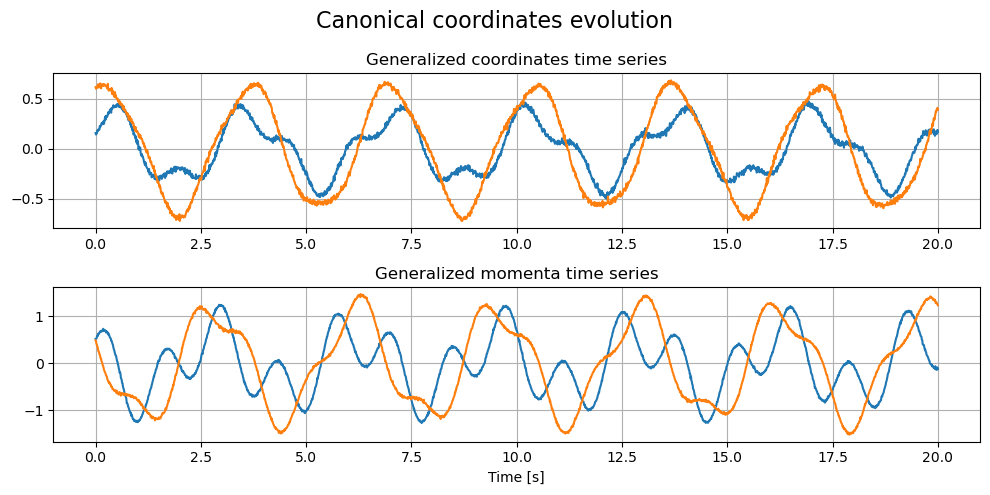

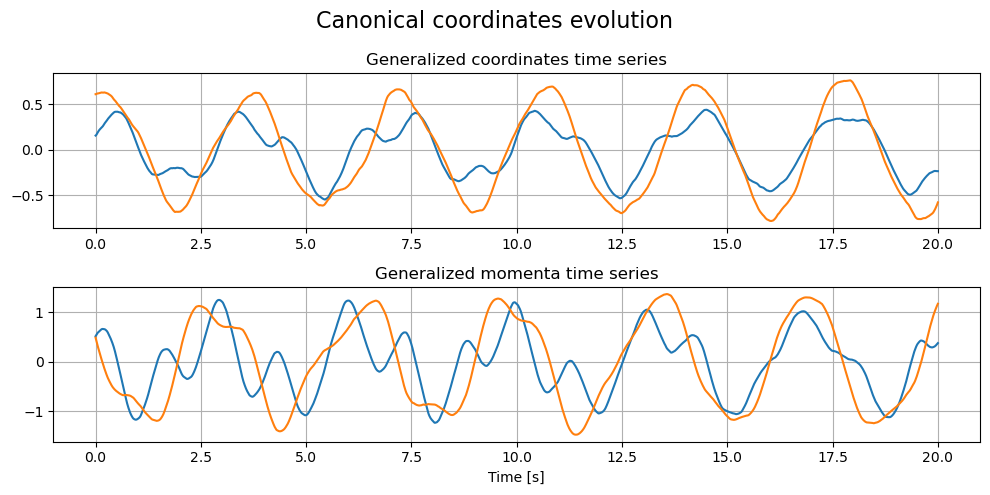

In [30]:
trajectory_truth = inputs[0, :, :]
initial_conditions = trajectory_truth[0, :].requires_grad_(True)
t_span = (t_init, t_final)

trajectory_hamiltonian_model = autoregressive_rollout_ivp(
    model=hamiltonian_model,
    initial_conditions=initial_conditions,
    t_span=t_span,
    n_steps=n_steps,
)

plot_canonical_time_series(t_eval, trajectory_truth)
plot_canonical_time_series(t_eval, trajectory_hamiltonian_model)

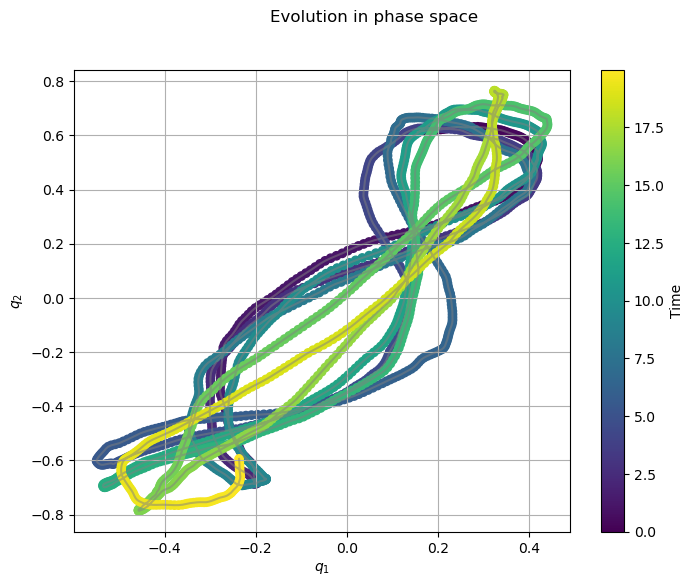

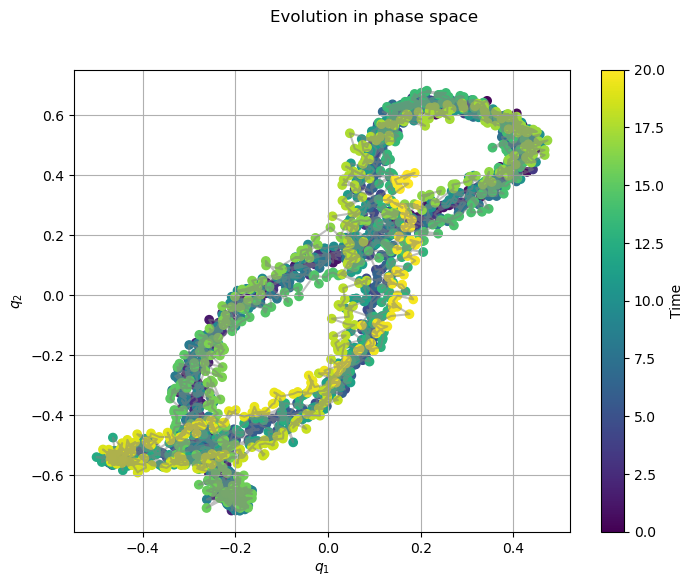

In [31]:
hamiltonian_model_gen_coords = np.array(
    [np.array(system.canonical_to_generalized(trajectory_hamiltonian_model[i, :])) for i in range(n_steps)]
)

plot_phase_space_quiver(
    t_eval[:t_stop],
    hamiltonian_model_gen_coords[:t_stop],
    quiver=False,
)

plot_phase_space_quiver(
    t_eval,
    ground_truth_gen_coords,
    quiver=False,
)

### Hamiltonian Neural Network Model with NeuralODE-like training

Use a HNN to approximate system dynamics and train NeuralODE-style

In [32]:
hamiltonian_core_model = MLP(
    input_dim=input_dim,
    output_dim=1,
    hidden_dim=hidden_dim,
    n_hidden_layers=n_hidden_layers,
).to(device)

hamiltonian_neural_ode_model = HamiltonianNeuralNetwork(
    input_dim=input_dim,
    core_model=hamiltonian_core_model,
).to(device)


dynamics = HamiltonianDynamics(hamiltonian_neural_ode_model).to(device)

optimizer = torch.optim.Adam(
    dynamics.parameters(), 
    lr=5e-4,
)

train_losses = []
test_losses = []
dynamics.train()

y0 = train_inputs[0, 0, :].requires_grad_(True)
y_target = train_inputs[0, :, :].requires_grad_(True)
t_ = torch.tensor(t_eval)[:len(y_target)]

for epoch in range(25):
    
    optimizer.zero_grad()

    y_pred = odeint(
        func=dynamics,
        y0=y0,
        t=t_,
    )

    train_loss = mse_loss_fn(y_pred, y_target)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())

    if (epoch + 1) % 1 == 0:
        print(f" ---- Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")


 ---- Epoch 1/2000
Train Loss: 0.6246
 ---- Epoch 2/2000
Train Loss: 0.5973
 ---- Epoch 3/2000
Train Loss: 0.5720
 ---- Epoch 4/2000
Train Loss: 0.5446
 ---- Epoch 5/2000
Train Loss: 0.5152
 ---- Epoch 6/2000
Train Loss: 0.4865
 ---- Epoch 7/2000
Train Loss: 0.4593
 ---- Epoch 8/2000
Train Loss: 0.4333
 ---- Epoch 9/2000
Train Loss: 0.4146
 ---- Epoch 10/2000
Train Loss: 0.3954
 ---- Epoch 11/2000
Train Loss: 0.3812
 ---- Epoch 12/2000
Train Loss: 0.3785
 ---- Epoch 13/2000
Train Loss: 0.3809
 ---- Epoch 14/2000
Train Loss: 0.3771
 ---- Epoch 15/2000
Train Loss: 0.3773
 ---- Epoch 16/2000
Train Loss: 0.3760
 ---- Epoch 17/2000
Train Loss: 0.3721
 ---- Epoch 18/2000
Train Loss: 0.3658
 ---- Epoch 19/2000
Train Loss: 0.3607
 ---- Epoch 20/2000
Train Loss: 0.3569
 ---- Epoch 21/2000
Train Loss: 0.3586
 ---- Epoch 22/2000
Train Loss: 0.3614
 ---- Epoch 23/2000
Train Loss: 0.3616
 ---- Epoch 24/2000
Train Loss: 0.3613
 ---- Epoch 25/2000
Train Loss: 0.3621


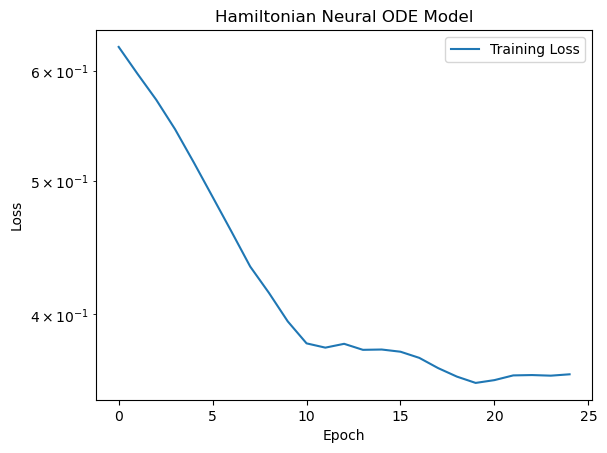

In [33]:
plt.plot(train_losses, label='Training Loss')
plt.title('Hamiltonian Neural ODE Model')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

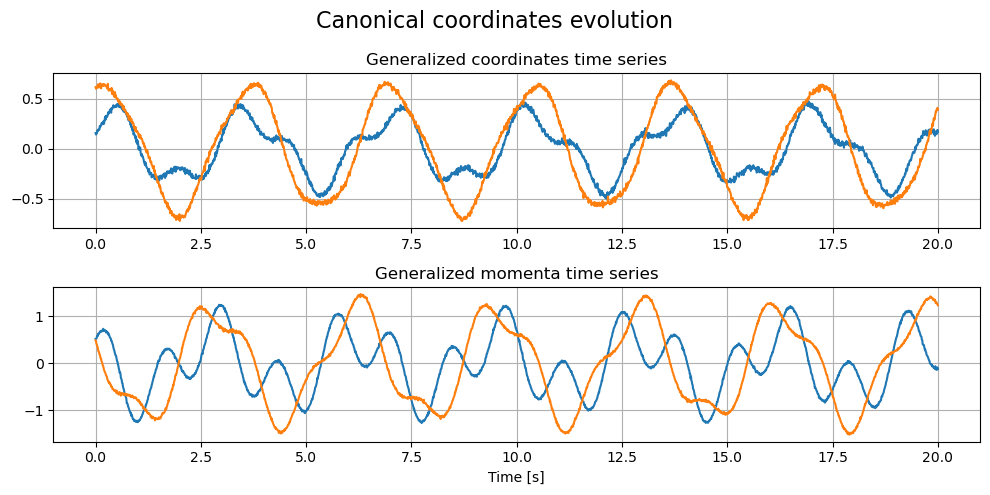

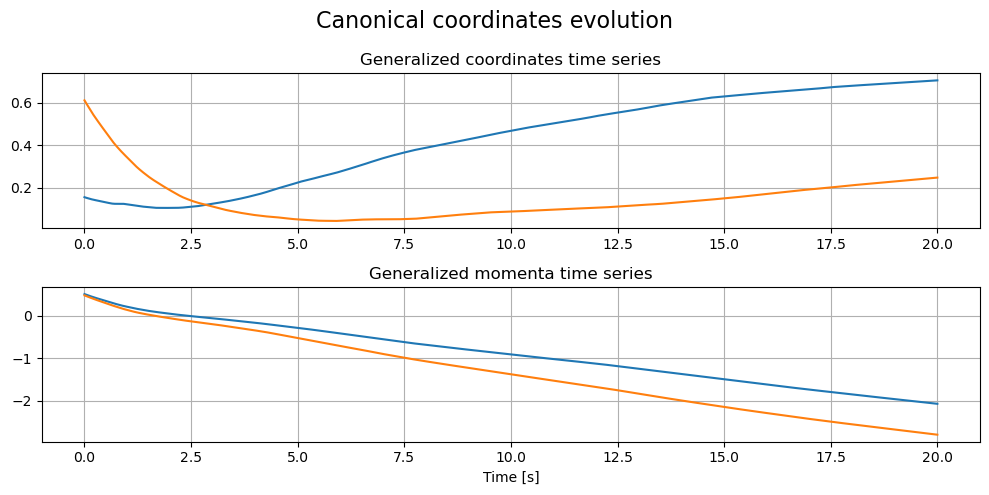

In [34]:
t_span = (t_init, t_final)
t_eval = np.linspace(t_init, t_final, n_steps)

trajectory_truth = inputs[0, :, :]
initial_conditions = trajectory_truth[0, :].requires_grad_(True)

trajectory_hamiltonian_neural_ode_model = odeint(
    func=dynamics,
    y0=initial_conditions,
    t=torch.tensor(t_eval),
).detach().numpy()

plot_canonical_time_series(t_eval, trajectory_truth)
plot_canonical_time_series(t_eval, trajectory_hamiltonian_neural_ode_model)